In [193]:
from importlib import reload
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import layers

In [205]:
# import modules
import src.models
reload(src.models)
from src.models import *

import src.dataMethods
reload(src.dataMethods)
from src.dataMethods import *

In [136]:
with open('stds_dict.json', 'w') as f:
    json.dump(stds, f)

In [139]:
with open('params/means_dict.json', 'r') as f:
    means = json.load(f)
print(means[''])

-20.80355745187809


In [153]:
# open up the gestures text file, which contains a list of possible gestures
with open('params/gestures.txt') as f:
    gestures = f.read()
    gestures = gestures.split()

g2idx = {g: i for i, g in enumerate(gestures)}
idx2g = {i: g for i, g in enumerate(gestures)}
print(g2idx)

{'no_gesture': 0, 'fist': 1, 'gun': 2, 'hitchhiking': 3, 'open_close': 4, 'pointing': 5, 'shuffle_over': 6, 'so_so': 7}


In [206]:
# get data frame with the variables of interest
# create empty data frame
df = pd.DataFrame()
# read in all training data from loops directory
for file in os.scandir('data/loops/'):
    df2 = CSV2VoI(file)
    df = pd.concat([df, df2], ignore_index=True)

mean fps: 115.19
target fps: 25
skipping every 5 frames
Found left hand data:  True
Found right hand data:  True
mean fps: 115.21
target fps: 25
skipping every 5 frames
Found left hand data:  True
Found right hand data:  True


In [207]:
# extract X and y
X_contiguous, y_contiguous = df2X_y(df, g2idx)
X, y = X_y2examples(X_contiguous, y=y_contiguous, n_frames=25)
synced_shuffle(X, y)

dropped 0 of 11554 rows with nans
Index(['right_direction_0', 'right_grabAngle', 'right_index_tipPosition_0',
       'right_index_tipPosition_1', 'right_index_tipPosition_2',
       'right_middle_tipPosition_0', 'right_middle_tipPosition_1',
       'right_middle_tipPosition_2', 'right_palmVelocity_0',
       'right_palmVelocity_1', 'right_palmVelocity_2', 'right_pinchDistance',
       'right_pinky_tipPosition_0', 'right_pinky_tipPosition_1',
       'right_pinky_tipPosition_2', 'right_ring_tipPosition_0',
       'right_ring_tipPosition_1', 'right_ring_tipPosition_2',
       'right_thumb_tipPosition_0', 'right_thumb_tipPosition_1',
       'right_thumb_tipPosition_2'],
      dtype='object')


In [208]:
model = many2one_model(n_features = X.shape[-1], n_frames=X.shape[1], n_gestures=len(g2idx), rnn_units=32)

Model: "many2one"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 25, 21)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                6912      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
Total params: 7,176
Trainable params: 7,176
Non-trainable params: 0
_________________________________________________________________


In [209]:
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X, y, epochs=20, batch_size = 32, validation_split=0.1)

Train on 390 samples, validate on 44 samples
Epoch 1/20
390/390 [==============================] - 3s 7ms/sample - loss: 1.8562 - accuracy: 0.3795 - val_loss: 1.7519 - val_accuracy: 0.4545
Epoch 2/20
390/390 [==============================] - 0s 517us/sample - loss: 1.6420 - accuracy: 0.6051 - val_loss: 1.5738 - val_accuracy: 0.5682
Epoch 3/20
390/390 [==============================] - 0s 401us/sample - loss: 1.4514 - accuracy: 0.7026 - val_loss: 1.4001 - val_accuracy: 0.6136
Epoch 4/20
390/390 [==============================] - 0s 442us/sample - loss: 1.2739 - accuracy: 0.7359 - val_loss: 1.2302 - val_accuracy: 0.6364
Epoch 5/20
390/390 [==============================] - 0s 401us/sample - loss: 1.1092 - accuracy: 0.7615 - val_loss: 1.0808 - val_accuracy: 0.7045
Epoch 6/20
390/390 [==============================] - 0s 465us/sample - loss: 0.9637 - accuracy: 0.8000 - val_loss: 0.9489 - val_accuracy: 0.7727
Epoch 7/20
390/390 [==============================] - 0s 606us/sample - loss: 0.8

In [210]:
model.save('models/32HS8C.h5')

In [211]:
X, y = CSV2examples('data/recordings/fist_test.csv', g2idx=g2idx, n_frames=25)
pred = model.predict(np.expand_dims(np.array(X[1]), axis=0))
print(pred)
print(idx2g[np.argmax(pred)])

mean fps: 115.20
target fps: 25
skipping every 5 frames
Found left hand data:  True
Found right hand data:  True
dropped 0 of 194 rows with nans
Index(['right_direction_0', 'right_grabAngle', 'right_index_tipPosition_0',
       'right_index_tipPosition_1', 'right_index_tipPosition_2',
       'right_middle_tipPosition_0', 'right_middle_tipPosition_1',
       'right_middle_tipPosition_2', 'right_palmVelocity_0',
       'right_palmVelocity_1', 'right_palmVelocity_2', 'right_pinchDistance',
       'right_pinky_tipPosition_0', 'right_pinky_tipPosition_1',
       'right_pinky_tipPosition_2', 'right_ring_tipPosition_0',
       'right_ring_tipPosition_1', 'right_ring_tipPosition_2',
       'right_thumb_tipPosition_0', 'right_thumb_tipPosition_1',
       'right_thumb_tipPosition_2'],
      dtype='object')
[[0.00750856 0.86710876 0.04404884 0.03815367 0.01607343 0.00841826
  0.01521251 0.00347597]]
fist


In [177]:
print(idx2g[y[1]])

fist


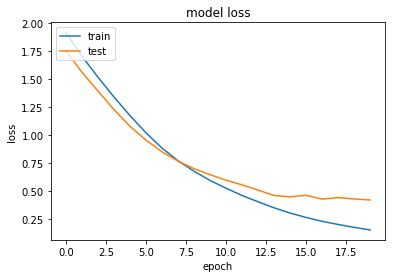

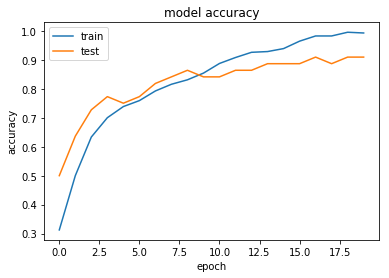

In [129]:
# plot history:
plt_metric(history, 'loss')
plt_metric(history, 'accuracy')

In [204]:
df.columns
df2 = df.reindex(sorted(df.columns), axis=1)
df.columns

Index(['gesture', 'left_index_tipPosition_0', 'left_index_tipPosition_1',
       'left_index_tipPosition_2', 'left_middle_tipPosition_0',
       'left_middle_tipPosition_1', 'left_middle_tipPosition_2',
       'left_ring_tipPosition_0', 'left_ring_tipPosition_1',
       'left_ring_tipPosition_2', 'left_pinky_tipPosition_0',
       'left_pinky_tipPosition_1', 'left_pinky_tipPosition_2',
       'left_thumb_tipPosition_0', 'left_thumb_tipPosition_1',
       'left_thumb_tipPosition_2', 'left_palmVelocity_0',
       'left_palmVelocity_1', 'left_palmVelocity_2', 'left_pinchDistance',
       'left_grabAngle', 'left_direction_0', 'right_index_tipPosition_0',
       'right_index_tipPosition_1', 'right_index_tipPosition_2',
       'right_middle_tipPosition_0', 'right_middle_tipPosition_1',
       'right_middle_tipPosition_2', 'right_ring_tipPosition_0',
       'right_ring_tipPosition_1', 'right_ring_tipPosition_2',
       'right_pinky_tipPosition_0', 'right_pinky_tipPosition_1',
       'right_pi